

install libraries for STAC search, raster stacking, reprojection, export, and mapping.

In [1]:
!pip -q install pystac-client planetary-computer stackstac rasterio rioxarray geopandas shapely matplotlib folium branca


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 668.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pystac_client import Client
import planetary_computer as pc
import stackstac

import rasterio
import rioxarray  # adds .rio accessor
import xarray as xr

from shapely.geometry import box


Define Area Of Interest (Nebraska)

In [3]:
# AOI bounding box in lon/lat (WGS84)
# Lincoln, Nebraska area (small box for speed)
min_lon, min_lat = -96.80, 40.74
max_lon, max_lat = -96.60, 40.88

aoi = box(min_lon, min_lat, max_lon, max_lat)
bbox = [min_lon, min_lat, max_lon, max_lat]

print("AOI bbox:", bbox)


AOI bbox: [-96.8, 40.74, -96.6, 40.88]


Search Sentinel-2 items from STAC

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

collection = "sentinel-2-l2a"

# Two time windows to compare (cloud-filtered)
time_1 = "2024-06-01/2024-06-30"
time_2 = "2025-06-01/2025-06-30"

cloud_max = 20  # percent

def search_items(time_range):
    search = catalog.search(
        collections=[collection],
        bbox=bbox,
        datetime=time_range,
        query={"eo:cloud_cover": {"lt": cloud_max}},
        max_items=50
    )
    items = list(search.get_items())
    print(f"{time_range}: {len(items)} items found (cloud < {cloud_max}%)")
    return items

items_1 = search_items(time_1)
items_2 = search_items(time_2)

assert len(items_1) > 0 and len(items_2) > 0, "No items found—try increasing cloud_max or widening dates/AOI."


/usr/local/lib/python3.12/dist-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


2024-06-01/2024-06-30: 4 items found (cloud < 20%)
2025-06-01/2025-06-30: 16 items found (cloud < 20%)


Build NDVI composite

In [5]:
def build_ndvi_composite(items, epsg=32614, resolution=10):
    # Sign items for Planetary Computer access
    signed_items = [pc.sign(item) for item in items]

    # Load Red (B04) and NIR (B08)
    stack = stackstac.stack(
        signed_items,
        assets=["B04", "B08"],
        epsg=epsg,          # UTM zone 14N covers Nebraska (fast + meters)
        resolution=resolution,
        bounds_latlon=bbox,
        chunksize=2048
    ).astype("float32")

    # stack dims: time, band, y, x
    red = stack.sel(band="B04")
    nir = stack.sel(band="B08")

    # Cloud-robust composite
    red_med = red.median(dim="time", skipna=True)
    nir_med = nir.median(dim="time", skipna=True)

    ndvi = (nir_med - red_med) / (nir_med + red_med + 1e-6)
    ndvi = ndvi.clip(min=-1, max=1)

    return ndvi

ndvi_1 = build_ndvi_composite(items_1)
ndvi_2 = build_ndvi_composite(items_2)

# NDVI change map by computing inter-annual change between the two periods
ndvi_change = ndvi_2 - ndvi_1

ndvi_1, ndvi_2, ndvi_change


(<xarray.DataArray 'stackstac-1b46017215f2579fcc0f8f12ce0efdc1' (y: 1599, x: 1729)> Size: 11MB
 dask.array<clip, shape=(1599, 1729), dtype=float32, chunksize=(1599, 1729), chunktype=numpy.ndarray>
 Coordinates: (12/15)
   * y                                        (y) float64 13kB 4.528e+06 ... 4...
   * x                                        (x) float64 14kB 6.854e+05 ... 7...
     s2:snow_ice_percentage                   float64 8B 0.0
     s2:processing_baseline                   <U5 20B '05.10'
     s2:datatake_type                         <U8 32B 'INS-NOBS'
     s2:saturated_defective_pixel_percentage  float64 8B 0.0
     ...                                       ...
     sat:relative_orbit                       int64 8B 12
     s2:product_type                          <U7 28B 'S2MSI2A'
     constellation                            <U10 40B 'Sentinel 2'
     gsd                                      float64 8B 10.0
     proj:shape                               object 8B {10980}
 

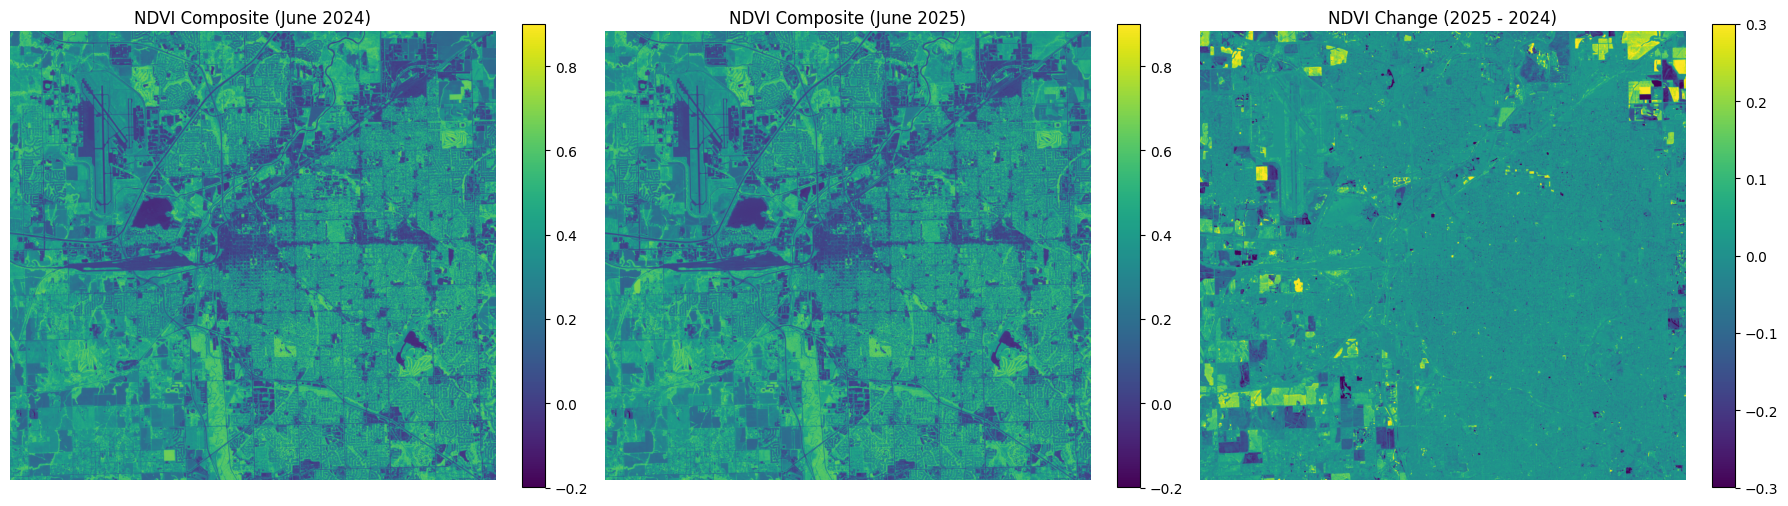

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].imshow(ndvi_1.values, vmin=-0.2, vmax=0.9)
axes[0].set_title("NDVI Composite (June 2024)")
axes[0].axis("off")
plt.colorbar(im1, ax=axes[0], fraction=0.046)

im2 = axes[1].imshow(ndvi_2.values, vmin=-0.2, vmax=0.9)
axes[1].set_title("NDVI Composite (June 2025)")
axes[1].axis("off")
plt.colorbar(im2, ax=axes[1], fraction=0.046)

im3 = axes[2].imshow(ndvi_change.values, vmin=-0.3, vmax=0.3)
axes[2].set_title("NDVI Change (2025 - 2024)")
axes[2].axis("off")
plt.colorbar(im3, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()


Export GeoTIFF outputs

In [7]:
import os

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

# Attach CRS from stackstac (already in ndvi arrays)
ndvi_1.rio.to_raster(f"{out_dir}/ndvi_june_2024.tif")
ndvi_2.rio.to_raster(f"{out_dir}/ndvi_june_2025.tif")
ndvi_change.rio.to_raster(f"{out_dir}/ndvi_change_2025_minus_2024.tif")

print("Saved GeoTIFFs in:", out_dir)
!ls -lh outputs


Saved GeoTIFFs in: outputs
total 32M
-rw-r--r-- 1 root root 11M Feb  8 03:16 ndvi_change_2025_minus_2024.tif
-rw-r--r-- 1 root root 11M Feb  8 03:15 ndvi_june_2024.tif
-rw-r--r-- 1 root root 11M Feb  8 03:16 ndvi_june_2025.tif


Interactive map to render NDVI change as an overlay on an interactive basemap.


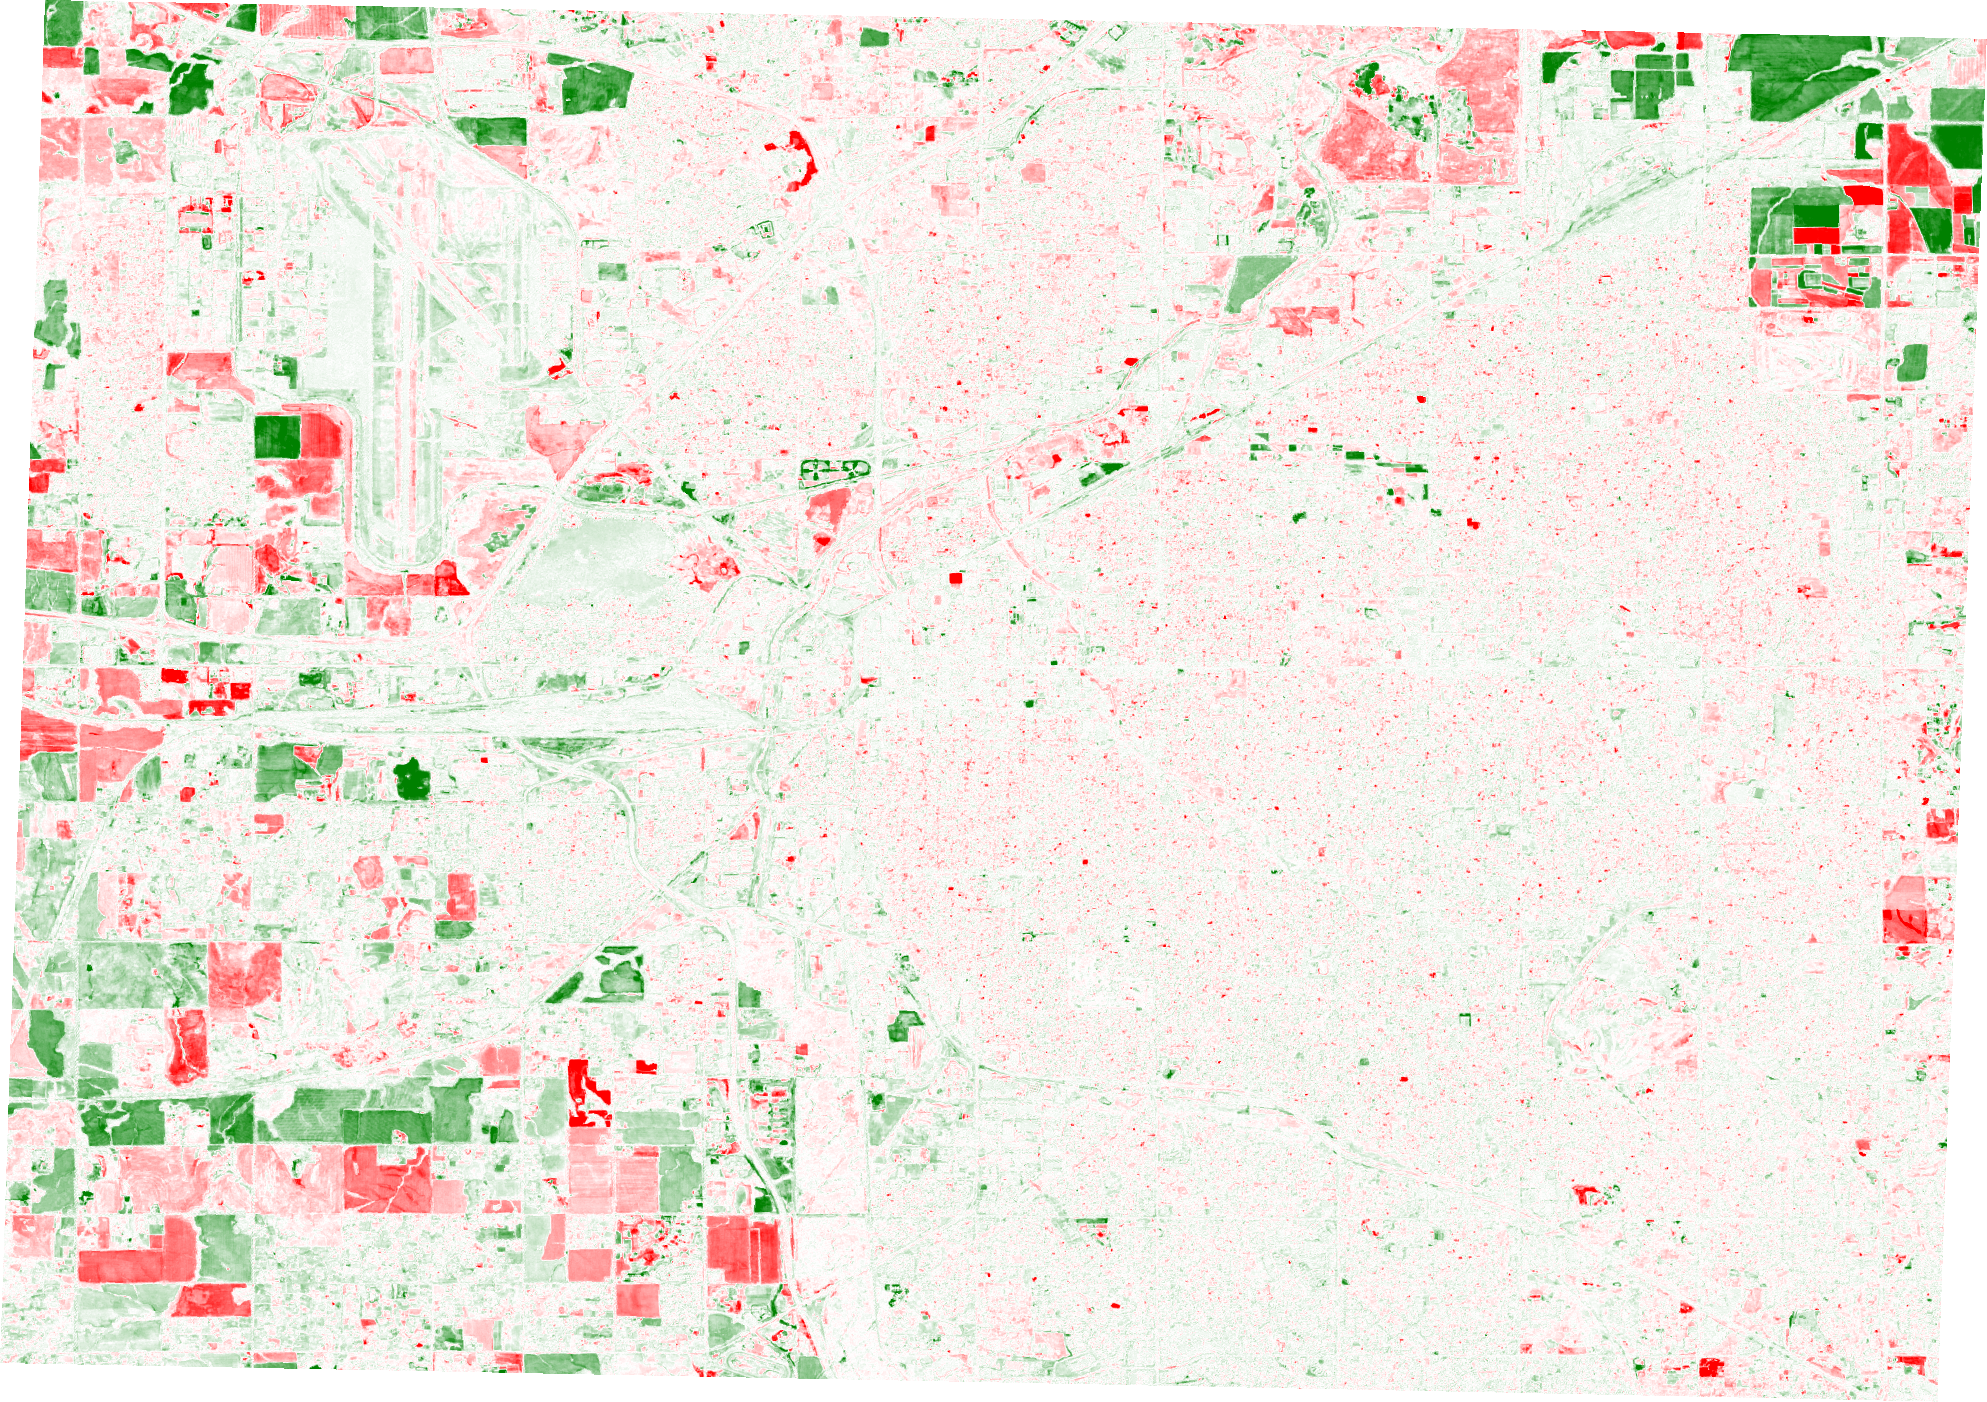

In [9]:
import folium
import branca.colormap as cm
from matplotlib.colors import LinearSegmentedColormap # Import for custom colormap

# Center map on AOI
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

# Convert arrays to image overlays by reprojecting to EPSG:4326 (lat/lon)
ndvi_change_ll = ndvi_change.rio.reproject("EPSG:4326")
bounds = [[min_lat, min_lon], [max_lat, max_lon]]

# Normalize for display
arr = ndvi_change_ll.values
vmin, vmax = -0.3, 0.3
norm = np.clip((arr - vmin) / (vmax - vmin), 0, 1)

# Create a matplotlib colormap that matches the red->white->green style
colors = ["red", "white", "green"]
cmap_mpl = LinearSegmentedColormap.from_list("ndvi_change_cmap", colors, N=256)

# Apply the matplotlib colormap to the normalized data to get RGBA values
rgba_mpl = cmap_mpl(norm)
rgba = np.uint8(rgba_mpl * 255)

folium.raster_layers.ImageOverlay(
    image=rgba,
    bounds=bounds,
    opacity=0.65,
    name="NDVI Change (2025 - 2024)"
).add_to(m)

# Use branca.colormap for the legend (it's good for this purpose)
cmap = cm.LinearColormap(colors, vmin=vmin, vmax=vmax)
cmap.caption = "NDVI Change"
cmap.add_to(m)

folium.LayerControl().add_to(m)
m